In [1]:
!pip install transformers accelerate datasets tokenizers seqeval -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00


In [2]:
# ! pip install spacy


In [3]:
from datasets import Dataset, ClassLabel, Sequence, load_dataset, load_metric
import numpy as np
import pandas as pd
# from spacy import displacy
import transformers
from transformers import (AutoModelForTokenClassification,
                          AutoTokenizer,
                          DataCollatorForTokenClassification,
                          pipeline,
                          TrainingArguments,
                          Trainer)

In [4]:
# confirm version > 4.11.0
print(transformers.__version__)

4.33.1


In [5]:
#dataset ADE-corpus-v2
#https://huggingface.co/datasets/ade_corpus_v2
datasets = load_dataset("ade_corpus_v2", "Ade_corpus_v2_drug_ade_relation")
# datasets

Generating train split:   0%|          | 0/6821 [00:00<?, ? examples/s]

In [6]:
# datasets["train"][0]
# datasets["train"].shape


In [7]:
# #draw the distribution of the text length
# import matplotlib.pyplot as plt

# # Assuming you have a list of texts like this:
# texts = datasets["train"]['text']

# # Calculate lengths of each text
# text_lengths = [len(text) for text in texts]

# # Plotting the histogram
# plt.figure(figsize=(12, 6))
# plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)  # You can adjust the number of bins as needed
# plt.title('Distribution of sentences Lengths')
# plt.xlabel('Text Length')
# plt.ylabel('Number of Texts')
# plt.grid(axis='y', linestyle='--')
# plt.show()


In [8]:
#same sentence maybe in multipe rows, merge into one
consolidated_dataset = {}

for row in datasets["train"]:
    if row["text"] in consolidated_dataset:
        # consolidated_dataset[row["text"]]["drug_indices_start"].update(row["indexes"]["drug"]["start_char"])
        # consolidated_dataset[row["text"]]["drug_indices_end"].update(row["indexes"]["drug"]["end_char"])
        consolidated_dataset[row["text"]]["effect_indices_start"].update(row["indexes"]["effect"]["start_char"])
        consolidated_dataset[row["text"]]["effect_indices_end"].update(row["indexes"]["effect"]["end_char"])
        # consolidated_dataset[row["text"]]["drug"].append(row["drug"])
        consolidated_dataset[row["text"]]["effect"].append(row["effect"])

    else:
        consolidated_dataset[row["text"]] = {
            "text": row["text"],
            # "drug": [row["drug"]],
            "effect": [row["effect"]],
            # use sets because the indices can repeat for various reasons
            # "drug_indices_start": set(row["indexes"]["drug"]["start_char"]),
            # "drug_indices_end": set(row["indexes"]["drug"]["end_char"]),
            "effect_indices_start": set(row["indexes"]["effect"]["start_char"]),
            "effect_indices_end": set(row["indexes"]["effect"]["end_char"])
        }

df = pd.DataFrame(list(consolidated_dataset.values()))


In [9]:
# df.shape

In [10]:
# df.head()


In [11]:
# #after merge the repreated sentences, plot each sentences word length distribution.
# #draw the distribution of the text length
# import matplotlib.pyplot as plt

# # Assuming you have a list of texts like this:
# texts = df['text']

# # Calculate lengths of each text
# text_lengths = [len(text) for text in texts]

# # Compute statistical measures
# mean_length = np.mean(text_lengths)
# std_length = np.std(text_lengths)

# # Plotting the histogram
# plt.figure(figsize=(12, 6))
# plt.hist(text_lengths, bins=30, color='blue', alpha=0.7, edgecolor='black')  # You can adjust the number of bins as needed

# # Adding vertical lines for mean and standard deviation
# plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=2, label=f'Mean = {mean_length:.2f}')
# plt.axvline(mean_length + std_length, color='g', linestyle='dashed', linewidth=2, label=f'Mean + 1 Std = {mean_length + std_length:.2f}')
# plt.axvline(mean_length - std_length, color='g', linestyle='dashed', linewidth=2, label=f'Mean - 1 Std = {mean_length - std_length:.2f}')

# plt.title('Distribution of Text Lengths with Mean and Std Dev')
# plt.xlabel('Text Length')
# plt.ylabel('Number of Texts')
# plt.legend()
# plt.grid(axis='y', linestyle='--')
# plt.tight_layout()
# plt.show()
# # # Plotting the histogram
# # plt.figure(figsize=(12, 6))
# # plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)  # You can adjust the number of bins as needed
# # plt.title('Distribution of Text Lengths in ADE_Corpus_V2')
# # plt.xlabel('Text Length')
# # plt.ylabel('Number of Texts')
# # plt.grid(axis='y', linestyle='--')
# # plt.show()


In [12]:
## since no spans overlap, we can sort to get 1:1 matched index spans
# note that sets don't preserve insertion order

# df["drug_indices_start"] = df["drug_indices_start"].apply(list).apply(sorted)
# df["drug_indices_end"] = df["drug_indices_end"].apply(list).apply(sorted)
df["effect_indices_start"] = df["effect_indices_start"].apply(list).apply(sorted)
df["effect_indices_end"] = df["effect_indices_end"].apply(list).apply(sorted)


In [13]:
# print(len(df['effect']))
# print(df.shape)
# print(df['text'][5],df['effect'][5], df['effect_indices_start'][5], df['effect_indices_end'][5])

import pandas as pd
from itertools import chain

# Flatten the lists in the 'effect' column
flattened_effects = list(chain.from_iterable(df['effect']))

# Count the distinct values
distinct_count = len(set(flattened_effects))
all_ae_count = len(flattened_effects)

print("Number of distinct count in 'Adverse Event' terms:", distinct_count)
print("Number of count in 'Adverse Event' terms:", all_ae_count)


# Count the number of terms in each list within 'effect' column
# df['num_terms'] = df['effect'].apply(lambda x: len(x))

# print("total number of Adverse Event Lables:",df['num_terms'].sum())

Number of distinct count in 'Adverse Event' terms: 3341
Number of count in 'Adverse Event' terms: 6821


In [14]:
# save to JSON to then import into Dataset object
df.to_json("dataset.jsonl", orient="records", lines=True)

In [15]:
cons_dataset = load_dataset("json", data_files="dataset.jsonl")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [16]:
# no train-test provided, so we create our own
#80% training 20%testing
# cons_dataset = cons_dataset["train"].train_test_split(test_size=0.2, seed=42)

cons_dataset = cons_dataset["train"].train_test_split(test_size=0.2, seed=42)



In [17]:
# cons_dataset

In [22]:
#fine-tuning
from transformers import AutoTokenizer

task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "bert-base-uncased"
batch_size = 16

# model_checkpoint = "biomednlp/pubmedbert-base-uncased-abstract"
model_checkpoint = "bert-base-uncased"
# model_checkpoint = "allenai/scibert_scivocab_uncased"
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
import pandas as pd
from itertools import chain

# Flatten the lists in the 'effect' column
flattened_effects = list(chain.from_iterable(cons_dataset['train']['effect']))

# Count the distinct values
distinct_count = len(set(flattened_effects))
total_count = len(flattened_effects)
print("Number of distinct count in 'Adverse Event' terms in training:", distinct_count)
print("Number of count in 'Adverse Event' terms in training:", total_count)

flattened_effects = list(chain.from_iterable(cons_dataset['test']['effect']))

# Count the distinct values
distinct_count = len(set(flattened_effects))
total_count = len(flattened_effects)
print("Number of distinct count in 'Adverse Event' terms in testing:", distinct_count)
print("Number of count in 'Adverse Event' terms in testing:", total_count)




Number of distinct count in 'Adverse Event' terms in training: 2837
Number of count in 'Adverse Event' terms in training: 5471
Number of distinct count in 'Adverse Event' terms in testing: 903
Number of count in 'Adverse Event' terms in testing: 1350


In [24]:
#define the 3 labels
# label_list = ['O', 'B-DRUG', 'I-DRUG', 'B-EFFECT', 'I-EFFECT']
label_list = ['O', 'B-AE', 'I-AE']



custom_seq = Sequence(feature=ClassLabel(num_classes=3,
                                         names=label_list,
                                         names_file=None, id=None), length=-1, id=None)

cons_dataset["train"].features["ner_tags"] = custom_seq
cons_dataset["test"].features["ner_tags"] = custom_seq

In [25]:
#function to generate BIO tags for effect
def generate_row_labels(row, verbose=False):
    """ Given a row from the consolidated `Ade_corpus_v2_drug_ade_relation` dataset,
    generates BIO tags for drug and effect entities.

    """

    text = row["text"]

    labels = []
    label = "O"
    prefix = ""

    # while iterating through tokens, increment to traverse all drug and effect spans
    # drug_index = 0
    effect_index = 0

    tokens = tokenizer(text, return_offsets_mapping=True)

    for n in range(len(tokens["input_ids"])):
        offset_start, offset_end = tokens["offset_mapping"][n]

        # should only happen for [CLS] and [SEP]
        if offset_end - offset_start == 0:
            labels.append(-100)
            continue

        # if drug_index < len(row["drug_indices_start"]) and offset_start == row["drug_indices_start"][drug_index]:
        #     label = "DRUG"
        #     prefix = "B-"

        if effect_index < len(row["effect_indices_start"]) and offset_start == row["effect_indices_start"][effect_index]:
            label = "AE"
            prefix = "B-"

        labels.append(label_list.index(f"{prefix}{label}"))

        # if drug_index < len(row["drug_indices_end"]) and offset_end == row["drug_indices_end"][drug_index]:
        #     label = "O"
        #     prefix = ""
        #     drug_index += 1

        if effect_index < len(row["effect_indices_end"]) and offset_end == row["effect_indices_end"][effect_index]:
            label = "O"
            prefix = ""
            effect_index += 1

        # need to transition "inside" if we just entered an entity
        if prefix == "B-":
            prefix = "I-"

    if verbose:
        print(f"{row}\n")
        orig = tokenizer.convert_ids_to_tokens(tokens["input_ids"])
        for n in range(len(labels)):
            print(orig[n], labels[n])
    tokens["labels"] = labels

    return tokens

In [26]:
#labeled_dataset
labeled_dataset = cons_dataset.map(generate_row_labels)


Map:   0%|          | 0/3416 [00:00<?, ? examples/s]

Map:   0%|          | 0/855 [00:00<?, ? examples/s]

In [27]:
# labeled_dataset['train']
# labeled_dataset['test']

In [28]:
# word will be splitted into subwords
#test the generate_row_labels function
# generate_row_labels(cons_dataset["train"][0], verbose=True)


In [29]:
!pip install accelerate -U
# !pip install transformers[torch]

In [30]:
model_name = model_checkpoint.split("/")[-1]
# from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.05,
    logging_steps=1
)

In [31]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")


<ipython-input-31-053592a2c97e>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [32]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # results = metric.compute(predictions=true_predictions, references=true_labels)
    #flat the prediction result
    flat_y_true = [item for sublist in true_labels for item in sublist]
    flat_y_pred = [item for sublist in true_predictions for item in sublist]

    #use the macro average precision, recall, f1 for training
    precision = precision_score(flat_y_true, flat_y_pred, average='macro')
    recall = recall_score(flat_y_true, flat_y_pred, average='macro')
    f1 = f1_score(flat_y_true, flat_y_pred, average='macro')
    accuracy = accuracy_score(flat_y_true, flat_y_pred)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        # "precision": results["overall_precision"],
        # "recall": results["overall_recall"],
        # "f1": results["overall_f1"],
        # "accuracy": results["overall_accuracy"],
    }

In [33]:
# cons_dataset = cons_dataset["train"].train_test_split(test_size=0.2, seed=42)

lltraindata = labeled_dataset['train'].train_test_split(test_size=0.2,seed=42)
# print(lltraindata)

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, classification_report


In [35]:
# trainer = Trainer(
#     model,
#     args,
#     train_dataset=lltraindata["train"],
#     eval_dataset=lltraindata["test"],
#     data_collator=data_collator,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,

# )
trainer = Trainer(
    model,
    args,
    train_dataset=labeled_dataset["train"],
    eval_dataset=labeled_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [36]:
trainer.train()


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.148700,0.143616,0.872444,0.917374,0.893605,0.948808
2,0.176100,0.122045,0.906135,0.921897,0.913845,0.958664
3,0.225200,0.120883,0.908109,0.928040,0.917792,0.960842


TrainOutput(global_step=642, training_loss=0.16928919280568758, metrics={'train_runtime': 153.2007, 'train_samples_per_second': 66.893, 'train_steps_per_second': 4.191, 'total_flos': 329583927963600.0, 'train_loss': 0.16928919280568758, 'epoch': 3.0})

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, classification_report

predictions, labels, _ = trainer.predict(labeled_dataset["test"])
# print(predictions)
#neural network output classification
predictions = np.argmax(predictions, axis=2)
# print(predictions)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
# print(true_predictions)

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
print("number of text in prediction:",len(true_predictions))
# print(len(true_labels))
print("predict labels",true_predictions)
print("true labels",true_labels)
# results = metric.compute(predictions=true_predictions, references=true_labels)
# print(results)

flat_y_true = [item for sublist in true_labels for item in sublist]
flat_y_pred = [item for sublist in true_predictions for item in sublist]
print("totoal number of labels in prediction:",len(flat_y_true))


precision = precision_score(flat_y_true, flat_y_pred, average='macro')
recall = recall_score(flat_y_true, flat_y_pred, average='macro')
f1 = f1_score(flat_y_true, flat_y_pred, average='macro')
accuracy = accuracy_score(flat_y_true, flat_y_pred)

print("Macro Precision:", precision)
print("Macro Recall:", recall)
print("Macro F1 Score:", f1)
print("Accuracy:", accuracy)

report = classification_report(flat_y_true, flat_y_pred, output_dict=True)

# report



number of text in prediction: 855
predict labels [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'B-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'O', 'B-AE', 'I-AE', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'O', 'O'

{'B-AE': {'precision': 0.8397745571658615,
  'recall': 0.8914529914529915,
  'f1-score': 0.8648424543946932,
  'support': 1170},
 'I-AE': {'precision': 0.903537684025489,
  'recall': 0.9186773905272565,
  'f1-score': 0.9110446438462392,
  'support': 4476},
 'O': {'precision': 0.9810135897561694,
  'recall': 0.9739892839746712,
  'f1-score': 0.9774888177351942,
  'support': 20530},
 'accuracy': 0.9608419926650367,
 'macro avg': {'precision': 0.90810861031584,
  'recall': 0.9280398886516398,
  'f1-score': 0.9177919719920422,
  'support': 26176},
 'weighted avg': {'precision': 0.9614524718549933,
  'recall': 0.9608419926650367,
  'f1-score': 0.9610921044315822,
  'support': 26176}}

In [38]:
#use the table to show the evaluation result
eval_test_result = pd.DataFrame(report).transpose()

# eval_test_result

,precision,recall,f1-score,support
B-AE,0.839775,0.891453,0.864842,1170.000000
I-AE,0.903538,0.918677,0.911045,4476.000000
O,0.981014,0.973989,0.977489,20530.000000
accuracy,0.960842,0.960842,0.960842,0.960842
macro avg,0.908109,0.928040,0.917792,26176.000000
weighted avg,0.961452,0.960842,0.961092,26176.000000


In [39]:
#show dimensions
num_rows = len(true_predictions)
# Assuming each inner list can have a different length
num_cols_per_row = [len(row) for row in true_predictions]

# print("Number of rows for predictions:", num_rows)
# print("Number of columns in each row:", num_cols_per_row)


Number of rows for predictions: 855
Number of columns in each row: [38, 26, 15, 46, 24, 28, 28, 23, 16, 28, 23, 31, 37, 31, 51, 27, 53, 39, 23, 25, 28, 12, 23, 29, 23, 27, 31, 27, 16, 16, 37, 44, 27, 29, 29, 18, 35, 55, 20, 32, 53, 29, 23, 45, 21, 15, 27, 40, 22, 19, 51, 35, 84, 44, 14, 30, 15, 30, 28, 15, 29, 54, 25, 28, 36, 19, 19, 49, 40, 30, 46, 24, 32, 34, 31, 34, 24, 106, 13, 26, 12, 30, 26, 31, 27, 34, 20, 17, 50, 28, 23, 14, 28, 59, 27, 30, 60, 49, 18, 31, 13, 18, 41, 40, 64, 33, 45, 56, 19, 25, 22, 19, 22, 26, 62, 26, 26, 29, 45, 40, 40, 60, 17, 16, 29, 22, 22, 18, 15, 33, 45, 23, 29, 39, 47, 42, 23, 34, 46, 33, 27, 19, 39, 85, 42, 22, 26, 17, 44, 46, 19, 28, 29, 15, 13, 38, 18, 23, 47, 29, 64, 20, 37, 27, 50, 49, 23, 8, 38, 35, 44, 15, 47, 48, 30, 45, 47, 32, 25, 14, 18, 15, 48, 21, 40, 34, 17, 17, 44, 10, 24, 79, 30, 39, 41, 43, 51, 39, 21, 31, 24, 15, 21, 18, 22, 28, 12, 45, 22, 40, 23, 34, 14, 34, 49, 43, 15, 21, 28, 19, 15, 27, 42, 33, 30, 46, 40, 33, 19, 31, 27, 16, 13, 

In [40]:
# report

{'B-AE': {'precision': 0.8397745571658615,
  'recall': 0.8914529914529915,
  'f1-score': 0.8648424543946932,
  'support': 1170},
 'I-AE': {'precision': 0.903537684025489,
  'recall': 0.9186773905272565,
  'f1-score': 0.9110446438462392,
  'support': 4476},
 'O': {'precision': 0.9810135897561694,
  'recall': 0.9739892839746712,
  'f1-score': 0.9774888177351942,
  'support': 20530},
 'accuracy': 0.9608419926650367,
 'macro avg': {'precision': 0.90810861031584,
  'recall': 0.9280398886516398,
  'f1-score': 0.9177919719920422,
  'support': 26176},
 'weighted avg': {'precision': 0.9614524718549933,
  'recall': 0.9608419926650367,
  'f1-score': 0.9610921044315822,
  'support': 26176}}

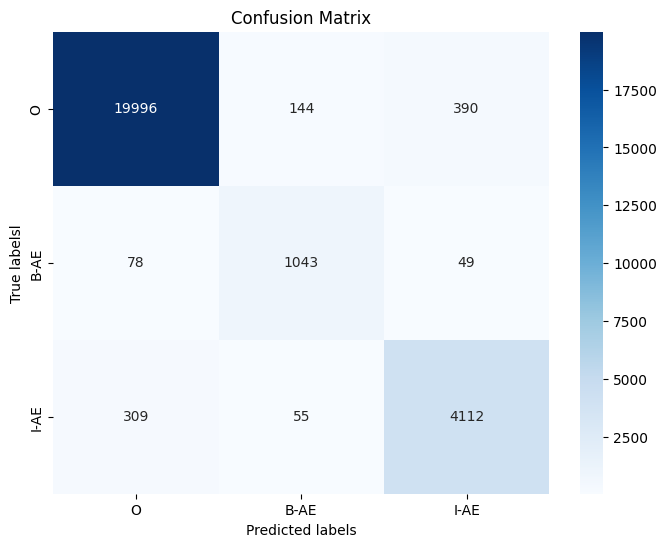

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Sample data
#flat_y_pred
#flat_y_true
label_list = ['O', 'B-AE', 'I-AE']

# Compute the confusion matrix
cm = confusion_matrix(flat_y_true, flat_y_pred, labels = label_list)

# Compute classification report
report = classification_report(flat_y_true, flat_y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plotting
plt.figure(figsize=(8,6))

# Confusion matrix heatmap
# sns.heatmap(cm, annot=True, fmt='g', ax=ax[0], cmap='Blues')

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',xticklabels=label_list, yticklabels=label_list)
plt.ylabel('True labelsl')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()


# # Bar chart for precision, recall, f1-score
# df_report[:-3].plot(kind='bar', y=['precision', 'recall', 'f1-score'], ax=ax[1])
# ax[1].set_title('Precision, Recall & F1 Score per Class')
# ax[1].set_ylabel('Score')
# ax[1].set_ylim([0, 1.1])
# plt.tight_layout()



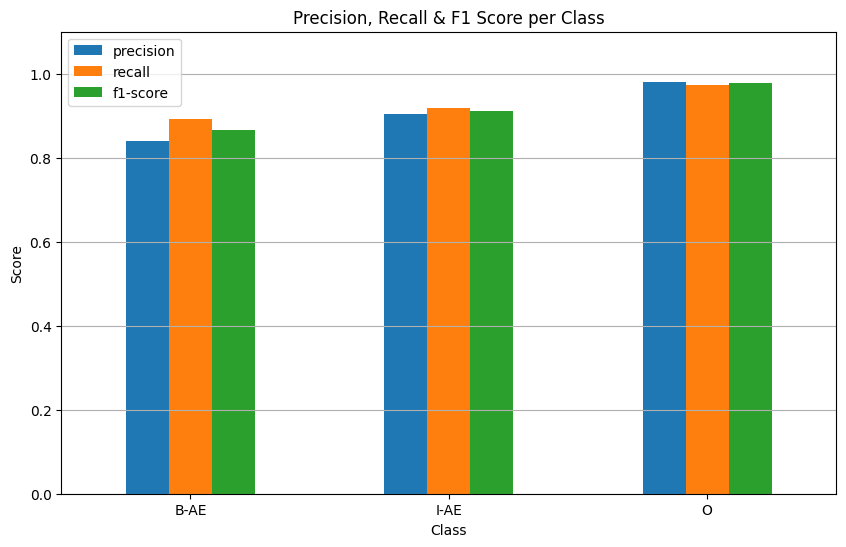

In [42]:
df_report = df_report[['precision', 'recall', 'f1-score']][:-3]

# Plot
df_report.plot(kind='bar', figsize=(10,6))
plt.title('Precision, Recall & F1 Score per Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

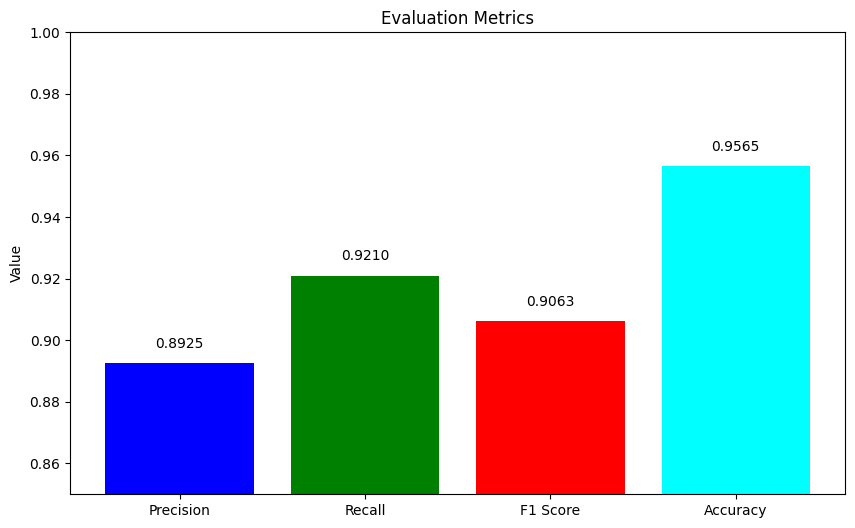

In [43]:
import matplotlib.pyplot as plt
metrics = {
    'Precision': 0.8925347342363213,
    'Recall': 0.9210316002318214,
    'F1 Score': 0.9062853884410021,
    'Accuracy': 0.9564994405072734
}
# Plotting
names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(10, 6))
plt.bar(names, values, color=['blue', 'green', 'red', 'cyan'])
plt.ylim(0.85, 1)  # Setting y-axis limits to better visualize differences
plt.ylabel('Value')
plt.title('Evaluation Metrics')
for i, v in enumerate(values):
    plt.text(i, v + 0.005, "{:.4f}".format(v), ha='center')  # Displaying the metric values on the bars

plt.show()

In [44]:

import os
from google.colab import drive

drive.mount('/content/drive')

save_dir = '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/'

# model.save_pretrained("general_ner_model")


model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


Mounted at /content/drive


('/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/tokenizer_config.json',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/special_tokens_map.json',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/vocab.txt',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/added_tokens.json',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/tokenizer.json')

In [49]:
effect_ner_model = pipeline(task="ner", model=model, tokenizer=tokenizer)


In [52]:
# effect_ner_model("this is a test for headache adverse event.")
# effect_ner_model("this is a test for headache adverse event.")
